# Reproduction of Fig. 4

In [1]:
import numpy as np
import pandas as pd
from pyscripts.config import path2
from pyscripts.datasets import Metadata
from pyscripts.visualization import ColorUniversalDesign as CUD
metadata = Metadata()

In [2]:
habitablity_scores = pd.read_pickle(path2.data/'prokatlas'/'summary.pkl.bz2')
idp_summary = pd.read_pickle(path2.data/'iupred2a'/'summary.pkl.bz2')
idp_summary = idp_summary.swaplevel(0,1,axis=1).swaplevel(1,2,axis=1).sort_index(axis=1)

In [3]:
gtdbrep2refseq = metadata.acc.set_index('gtdbrep')['refseq']
refseq2gtdbrep = metadata.acc.set_index('refseq')['gtdbrep']
acc_ordered = pd.DataFrame([
    (refseq_acc, gtdb_acc)
    for gtdb_acc in metadata.bac120_tree.iter_leaf_names() 
    if (refseq_acc := gtdbrep2refseq.get(gtdb_acc)) is not None
], columns=['refseq', 'gtdbrep'])
gtdb_taxonomy = metadata.taxrank_inuse.loc[acc_ordered['gtdbrep']]

phylum_counts = gtdb_taxonomy['phylum'].value_counts()[gtdb_taxonomy['phylum'].unique()]
top_idx = phylum_counts[phylum_counts >= 40].sort_values(ascending=False).index
phylum_masked = gtdb_taxonomy['phylum'].where(gtdb_taxonomy['phylum'].isin(top_idx), '(others)')
phylum_color = (phylum_counts.rank(method='first', ascending=False).astype(int)-1).apply(CUD.OkabeIto_cmap)

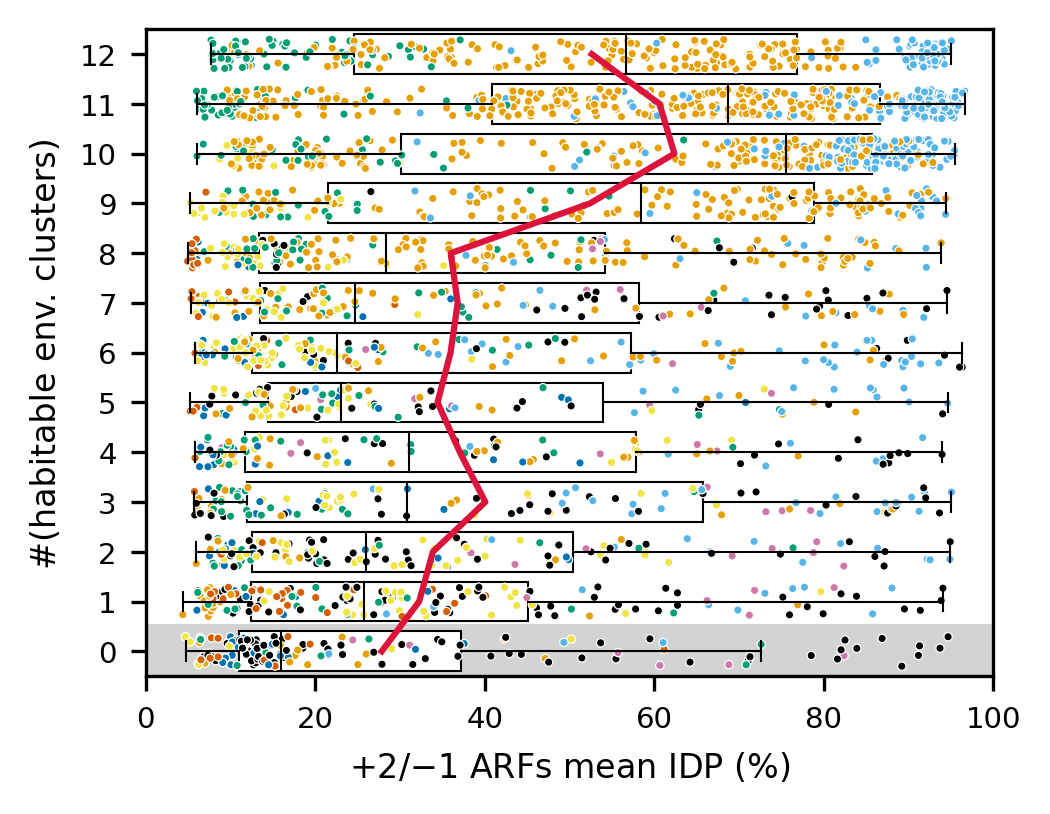

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

pltdat = pd.concat([
    (habitablity_scores > 0).sum(),
    (idp_summary[30, 0.5] / idp_summary[30, 0]).loc[[4,16]].mean().fillna(0) * 100,
    refseq2gtdbrep.map(phylum_masked)
], axis=1, keys=['#envs', 'IDP%', 'phylum'])

mm = 1 / 25.4
with plt.rc_context({'font.size': 8, 'grid.linewidth': 0.5, 'xtick.labelsize': 7, 'ytick.labelsize': 7}):
    fig, ax = plt.subplots(figsize=(90*mm, 70*mm), dpi=300)
    conf=dict(zorder=1, c='k')
    sns.boxplot(
        x='IDP%', y='#envs', data=pltdat,
        color='w', orient='h', linewidth=0.5, ax=ax, 
        capprops=conf, whiskerprops=conf, medianprops=conf, 
        boxprops=dict(zorder=0, ec='k'), showfliers = False
    )
    sns.stripplot(
        x='IDP%', y='#envs', hue='phylum', hue_order=[*top_idx, '(others)'], data=pltdat, 
        jitter=0.3, s=2, orient='h', ec='w', linewidth=0.3, palette=CUD.OkabeIto_cpal, ax=ax, zorder=1
    )
    sns.lineplot(
        x='IDP%', y='#envs', data=pltdat.groupby('#envs').mean(), 
        markers=True, color='crimson', sort=False, ax=ax, zorder=2
    )
    ax.legend().remove()
    ax.set_xlabel('$+2$/$-1$ ARFs mean IDP (%)')
    ax.set_ylabel('#(habitable env. clusters)')
    ax.set_xlim(0, 100)
    ax.set_ylim(-0.5, 12.5)
    ax.fill_between((0, 100), -0.5, 0.5, color='lightgray', zorder=0)
    fig.tight_layout()
    fig.savefig('./Figs/Fig4b.pdf')

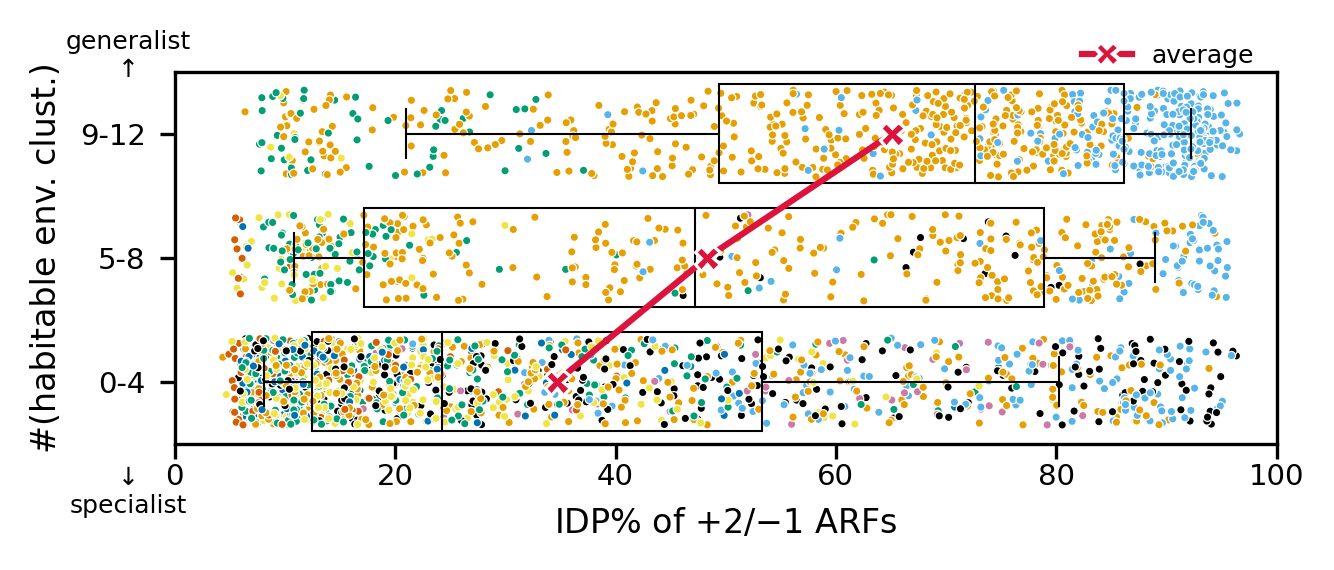

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

pltdat = pd.concat([
    (habitablity_scores > 10).sum(),
    (idp_summary[30, 0.5] / idp_summary[30, 0]).loc[[4,16]].mean().fillna(0) * 100,
    refseq2gtdbrep.map(phylum_masked)
], axis=1, keys=['#envs', 'IDP%', 'phylum'])

pltdat['#envs'] = pltdat['#envs'].map({
    0:  '0-4',  1:  '0-4',  2:  '0-4',  3:  '0-4', 4: '0-4',
    5:  '5-8',  6:  '5-8',  7:  '5-8',  8:  '5-8',
    9: '9-12', 10: '9-12', 11: '9-12', 12: '9-12'
})

mm = 1 / 25.4
with plt.rc_context({'font.size': 8, 'grid.linewidth': 0.5, 'xtick.labelsize': 7, 'ytick.labelsize': 7}):
    fig, ax = plt.subplots(figsize=(114*mm, 45*mm), dpi=300)
    conf=dict(zorder=1, c='k')
    sns.boxplot(
        x='IDP%', y='#envs', data=pltdat, order=['0-4', '5-8', '9-12'],
        color='w', orient='h', linewidth=0.5, ax=ax, 
        capprops=conf, whiskerprops=conf, medianprops=conf, 
        boxprops=dict(zorder=1, ec='k', fc='none'), whis=[10, 90], showfliers=False, 
    )
    sns.stripplot(
        x='IDP%', y='#envs', order=['0-4', '5-8', '9-12'], hue='phylum', hue_order=[*top_idx, '(others)'], data=pltdat, 
        jitter=0.35, s=2, orient='h', ec='w', linewidth=0.3, palette=CUD.OkabeIto_cpal, ax=ax, zorder=1
    )
    
    sns.lineplot(
        x='IDP%', y='#envs', data=pltdat.groupby('#envs').mean().loc[['0-4', '5-8', '9-12']].reset_index().assign(sty='mean'),
        color='crimson', sort=False, ax=ax, zorder=2, lw=1.5, style='sty', markers='X'
    )
    #ax.legend(plt.boxplot())
    #han, lab = ax.get_legend_handles_labels()
    ax.legend([plt.Line2D([0], [0], color='crimson', marker='X', mec='w')], ['average'], frameon=False, bbox_to_anchor=(1, 0.95), loc='lower right', fontsize=6)
    fig.text(0.1, 0.93, 'generalist\n↑', fontsize=6, va='center', ha='center')
    fig.text(0.1, 0.11, '↓\nspecialist', fontsize=6, va='center', ha='center')
    ax.set_xlabel('IDP% of $+2$/$-1$ ARFs')
    ax.set_ylabel('#(habitable env. clust.)')
    ax.set_xlim(0, 100)
    ax.set_ylim(-0.5, 2.5)
    ax.xaxis.set_tick_params(pad=1)
    #ax.fill_between((0, 100), -0.5, 0.5, color='lightgray', zorder=0)
    fig.tight_layout()
    fig.subplots_adjust(top=0.9, bottom=0.2)
    fig.savefig('./Figs/Fig4b.pdf')
    